[View in Colaboratory](https://colab.research.google.com/github/neoaksa/HPC/blob/master/2.Bio%20Crystal%20Growth/bioCrystal.ipynb)

### Assumption and Strategy
The 3D bio-Crystal is generated by C++, the srouce can be found [here](https://https://github.com/neoaksa/HPC/blob/master/2.Bio%20Crystal%20Growth/Biological%20Crystal%20Growth.cc)

The output is [a csv file](https://github.com/neoaksa/HPC/blob/master/2.Bio%20Crystal%20Growth/crystal.csv) which marks all fixed particles of bio-crystal in the 3D space(x \* y \* z), where x, y, z are defined in advance.

Each particle follows some assumptions:
1. There is a initial fixed particle in the central of space
2. The following particles can be initialized at any point but out of a setting radius
3. Since a particle initialized, it can randomly move to any direction until stick to a fixed particle or out of space.
4. Total numbers of particle can not be larger than **MAXSIZE**
5. Radius can not be bigger than **MAXRADIUS**. If it is so big that reach to the edge of space, the program will be very slow since it is easy to out of space.

Here is my setting:
```C++
#define x 50 // a 50 by 50 by 50 space
#define y 50
#define z 50
#define MAXSIZE x*y*z/200 //HOW MANY PATICLES
#define MAXRADIUS (int)(x/3)-1 //THE MAX RADIUS
#define THREADNUM 8
```

Strategy:
1. Each particle is controlled by a thread as a private variable
2. The whole space is shared, but synchronized when updating a fixed particle
3. A variable **total** is shared and synchronized, which is used to record how many fixed particle
4. A variable **radius** is shared and synchronized, which is used to record the radius to the central of space.
5. A variable **points** is shared and synchronized, which is used to record the fixed particles' position, and output to CSV file.

### Visualization
**Step 1**: Download and read csv file from github

In [9]:
# !pip install -q xlrd
# clone git
!rm -r HPC
!git clone https://github.com/neoaksa/HPC.git

    
# Files from the cloned git repository.
!ls HPC/"2.Bio Crystal Growth"

import pandas as pd
header = ["x","y","z"]
df = pd.read_csv('HPC/2.Bio Crystal Growth/crystal.csv',index_col=None, 
                 header=None, usecols=[0,1,2], names=header)
df.head(10)
df.count()

Cloning into 'HPC'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 254 (delta 26), reused 0 (delta 0), pack-reused 197
Receiving objects: 100% (254/254), 765.54 KiB | 1.06 MiB/s, done.
Resolving deltas: 100% (98/98), done.
bioCrystal.ipynb	   Biological Crystal Growth.cc  crystal.csv  Readme.md
Biological Crystal Growth  Biological Crystal Growth.o	 example.csv


x    625
y    625
z    625
dtype: int64

**Step 2:** Create a 3D lattice and visualize from df

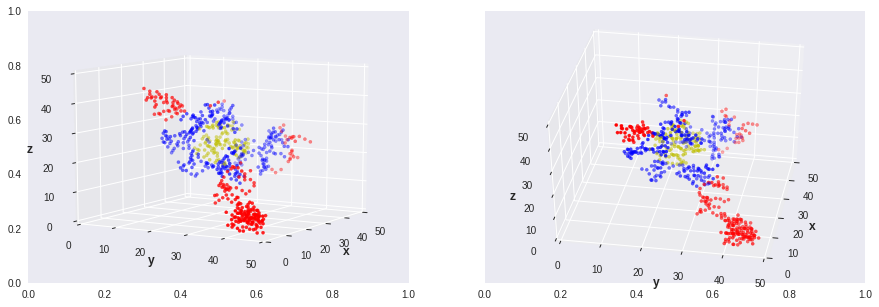

In [33]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Make the plot
fig, axearr = plt. subplots(1,2,sharex=True,sharey=True,figsize=(15,5))
axearr[0] = fig.add_subplot(1, 2, 1, projection='3d')
# setting label for axis rather plot
axearr[0].set_xlabel('x',size=12,fontweight='semibold') 
axearr[0].set_ylabel('y',size=12,fontweight='semibold') 
axearr[0].set_zlabel('z',size=12,fontweight='semibold') 
# size of lattice
x_size,y_size,z_size = 50,50,50
# set range of axis
axearr[0].set_xlim(0,x_size)
axearr[0].set_ylim(0,y_size)
axearr[0].set_zlim(0,z_size)
# invert x axis
axearr[0].invert_xaxis()
# set color by distance to center
df['dist'] = np.sqrt(np.square(df['x']-(int)(x_size/2))
                     + np.square(df['y']-(int)(y_size/2)) 
                     + np.square(df['z']-(int)(z_size/2)))
col = np.where(df['dist'].between(0,(int)(x_size/6),inclusive=True) ,'y',
               np.where(df['dist'].between((int)(x_size/6),(int)(x_size/3),
                                           inclusive=False)  ,'b','r'))
# set view angle
axearr[0].scatter(df['x'], df['y'], df['z'], s=10, color=col)
axearr[0].view_init(10, 30)

# another view
axearr[1] = fig.add_subplot(1, 2, 2, projection='3d')
# setting label for axis rather plot
axearr[1].set_xlabel('x',size=12,fontweight='semibold') 
axearr[1].set_ylabel('y',size=12,fontweight='semibold') 
axearr[1].set_zlabel('z',size=12,fontweight='semibold') 
# set range of axis
axearr[1].set_xlim(0,x_size)
axearr[1].set_ylim(0,y_size)
axearr[1].set_zlim(0,z_size)
# invert x axis
axearr[1].invert_xaxis()
# set color by distance to center
df['dist'] = np.sqrt(np.square(df['x']-(int)(x_size/2))
                     + np.square(df['y']-(int)(y_size/2)) 
                     + np.square(df['z']-(int)(z_size/2)))
col = np.where(df['dist'].between(0,(int)(x_size/6),inclusive=True) ,'y',
               np.where(df['dist'].between((int)(x_size/6),(int)(x_size/3),
                                           inclusive=False)  ,'b','r'))
# set view angle
axearr[1].scatter(df['x'], df['y'], df['z'], s=10, color=col)
axearr[1].view_init(40, 10)
plt.show()

###Analysis:
I run 5 time for the single and 8 threads respectly, and averaged the timing cost(unit: msec).

![alt text](https://github.com/neoaksa/HPC/blob/master/2.Bio%20Crystal%20Growth/imgs/Screenshot_20180929_013632.png?raw=true)

Speed up = 4.28

But if we scale the Max radius to the edge of space, the avg time will be like:

T(1 threads) = 371012 msec

T(8 threads) = 202981 msec

Speed up = 1.87

The speed up is decreased since out of space problem.
